In [65]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, levene
from statsmodels.stats.oneway import anova_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [66]:
# development_dataframe = pd.read_csv("/kaggle/input/health-insurance-cross-sell-prediction/train.csv")

development_dataframe = pd.read_csv("./input/train.csv")

# EDA

In [67]:
development_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [68]:
development_dataframe.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [69]:
train_df, val_df = train_test_split(development_dataframe, test_size=0.2, random_state=42, stratify=development_dataframe["Response"])

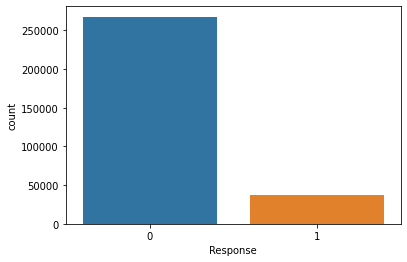

In [70]:
sns.countplot(x="Response", data=train_df)
plt.show()

### Does the gender impact on the upseling?

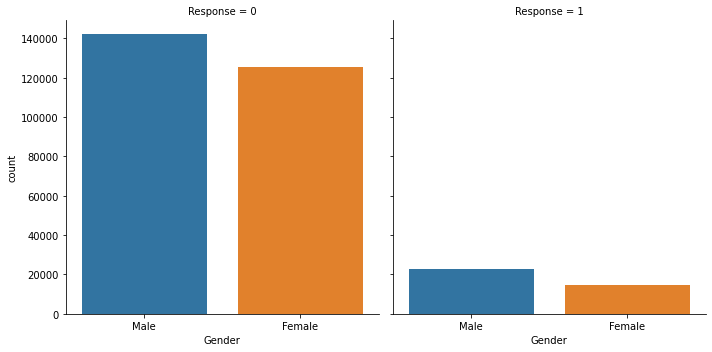

In [71]:
sns.catplot(x="Gender", col="Response", data=train_df, kind="count")
plt.show()

In [72]:
def test_categorical_independece(variables, response, data, alpha=0.05):
    dependet_variables = data[variables]
    response_data = data[response]

    insurance_response_contigency_table = pd.crosstab(dependet_variables, response_data)

    _, p_value, _, _ =chi2_contingency(insurance_response_contigency_table)

    if p_value <= alpha:
        print(f"p_value of {p_value}, distributions are dependent")
    else:
        print(f"p_value of {p_value}, distributions independent")

### Insurance predicts upseling?

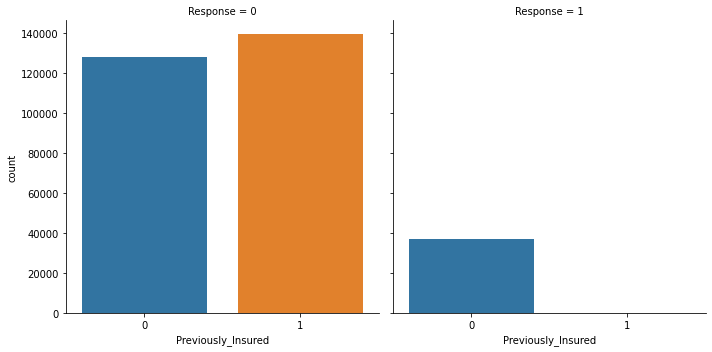

In [73]:
sns.catplot(x="Previously_Insured", col="Response", data=train_df, kind="count")
plt.show()

In [74]:
test_categorical_independece(variables="Previously_Insured", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Understand the impact of vehicle age

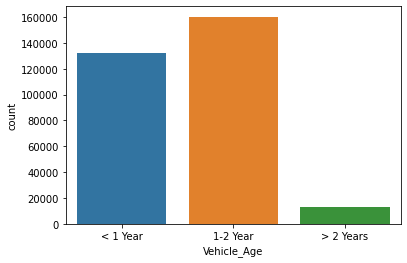

In [75]:
sns.countplot(x="Vehicle_Age", data=train_df)
plt.show()

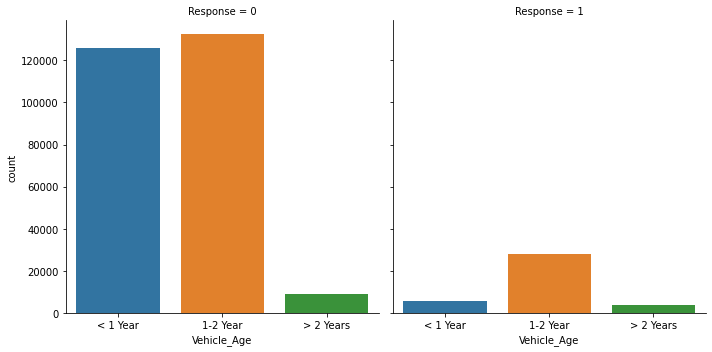

In [76]:
sns.catplot(x="Vehicle_Age", col="Response", data=train_df, kind="count")
plt.show()

In [77]:
test_categorical_independece(variables="Vehicle_Age", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Understand the impact of vehicle damage on upseling

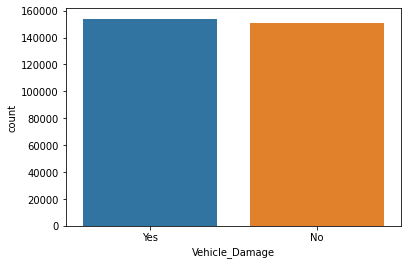

In [78]:
sns.countplot(x="Vehicle_Damage", data=train_df)
plt.show()

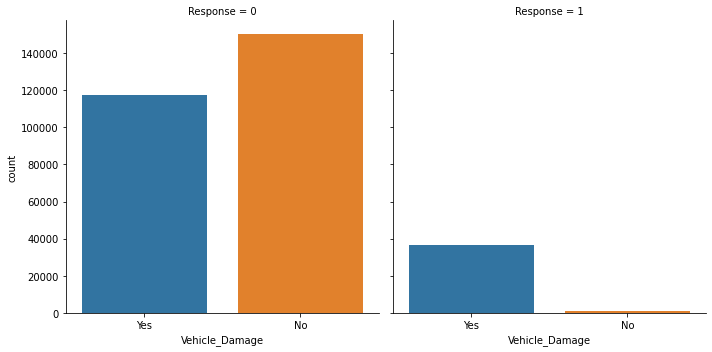

In [79]:
sns.catplot(x="Vehicle_Damage", col="Response", data=train_df, kind="count")
plt.show()

In [80]:
test_categorical_independece(variables="Vehicle_Damage", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Driving license

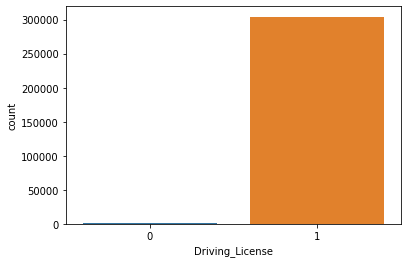

1    0.997855
0    0.002145
Name: Driving_License, dtype: float64

In [81]:
sns.countplot(x="Driving_License", data=train_df)
plt.show()

train_df["Driving_License"].value_counts(normalize=True)

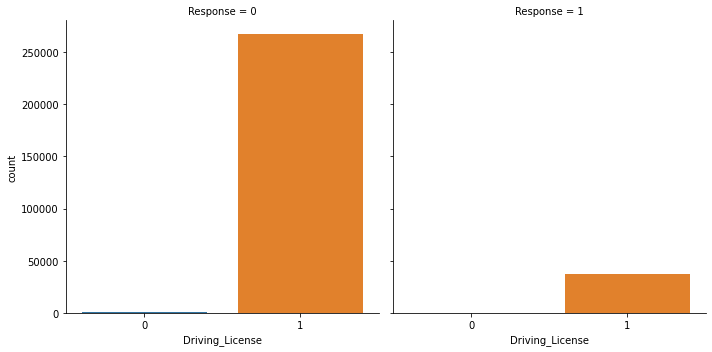

Driving_License  Response
0                0           0.948012
                 1           0.051988
1                0           0.877285
                 1           0.122715
Name: Response, dtype: float64

In [82]:
sns.catplot(x="Driving_License", col="Response", data=train_df, kind="count")
plt.show()

train_df.groupby("Driving_License")["Response"].value_counts(normalize=True)

In [83]:
test_categorical_independece(variables="Driving_License", response="Response", data=train_df)

p_value of 5.038720780124752e-08, distributions are dependent


### Check if premium impacts on upseling

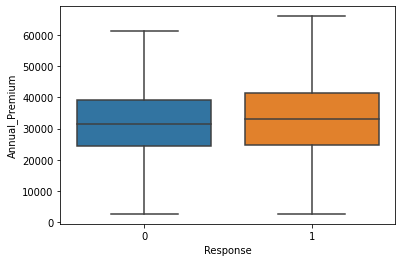

In [84]:
sns.boxplot(x="Response", y="Annual_Premium", showfliers=False, data=train_df)
plt.show()

In [85]:
train_df.groupby("Response")["Annual_Premium"].mean()

Response
0    30447.711157
1    31619.326054
Name: Annual_Premium, dtype: float64

In [86]:
no_cross_sell_premium = train_df.query("Response==0")["Annual_Premium"]
cross_sell_premium = train_df.query("Response==1")["Annual_Premium"]

_, p_value = ttest_ind(no_cross_sell_premium, cross_sell_premium, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Age impact

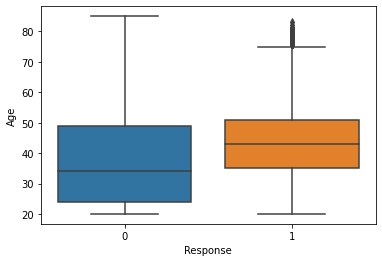

In [87]:
sns.boxplot(x="Response", y="Age", data=train_df)
plt.show()

In [88]:
no_cross_sell_age= train_df.query("Response==0")["Age"]
cross_sell_age = train_df.query("Response==1")["Age"]

_, p_value = ttest_ind(no_cross_sell_age, cross_sell_age, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Policy sales channel

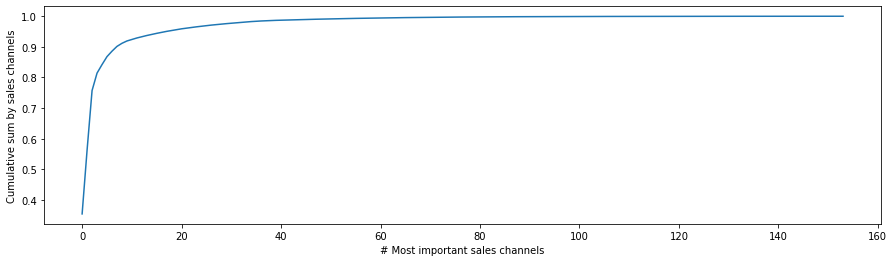

In [89]:
relative_count_most_important = train_df["Policy_Sales_Channel"].value_counts(normalize=True)

cumulative_sales_channels = np.cumsum(relative_count_most_important)
index = np.arange(len(cumulative_sales_channels))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_sales_channels, ax=ax)

ax.set_xlabel("# Most important sales channels")
ax.set_ylabel("Cumulative sum by sales channels")

plt.show()

### Analyse vintage

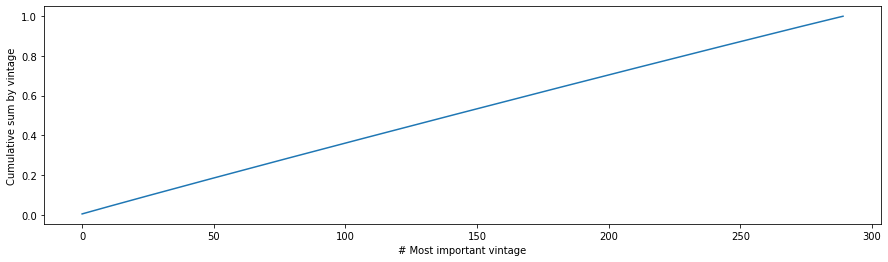

In [90]:
relative_count_most_important = train_df["Vintage"].value_counts(normalize=True)

cumulative_sales_channels = np.cumsum(relative_count_most_important)
index = np.arange(len(cumulative_sales_channels))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_sales_channels, ax=ax)

ax.set_xlabel("# Most important vintage")
ax.set_ylabel("Cumulative sum by vintage")

plt.show()

In [91]:
test_categorical_independece(variables="Vintage", response="Response", data=train_df)

p_value of 0.9825945874525271, distributions independent


### Analyse region code

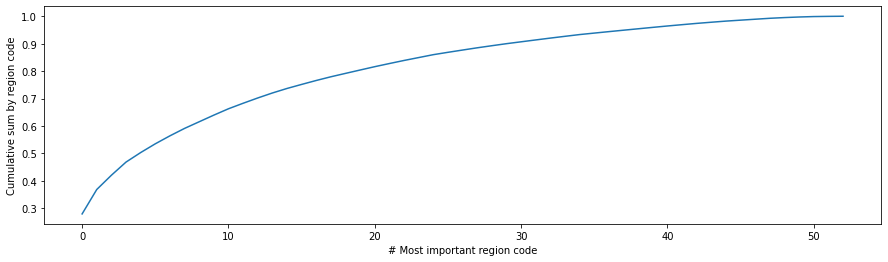

In [92]:
relative_count_most_important = train_df["Region_Code"].value_counts(normalize=True)

cumulative_sales_channels = np.cumsum(relative_count_most_important)
index = np.arange(len(cumulative_sales_channels))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_sales_channels, ax=ax)

ax.set_xlabel("# Most important region code")
ax.set_ylabel("Cumulative sum by region code")

plt.show()

In [93]:
test_categorical_independece(variables="Region_Code", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


## Draw relation between variables

### Age and Vehicule damage

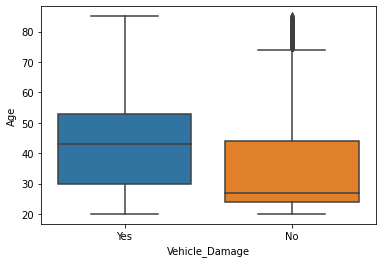

In [94]:
sns.boxplot(x="Vehicle_Damage", y="Age", data=train_df)
plt.show()

In [95]:
no_damage_age= train_df.query("Vehicle_Damage=='No'")["Age"]
damage_age = train_df.query("Vehicle_Damage=='Yes'")["Age"]

_, p_value = ttest_ind(no_damage_age, damage_age, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Impact of gender of vehicle damage

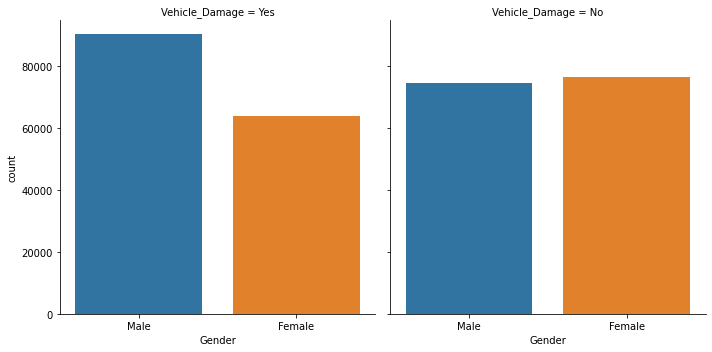

In [96]:
sns.catplot(x="Gender", col="Vehicle_Damage", data=train_df, kind="count")
plt.show()

In [97]:
test_categorical_independece(variables="Gender", response="Vehicle_Damage", data=train_df)

p_value of 0.0, distributions are dependent


### Correlation between age and premium

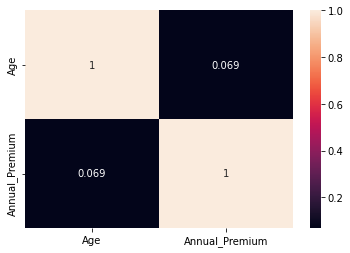

In [98]:
age_premium_correlation = train_df[["Age", "Annual_Premium"]].corr()

sns.heatmap(age_premium_correlation, annot=True)
plt.show()

### Relation between vehicle age and premium

In [99]:
less_one_year_premium = train_df.query("Vehicle_Age=='< 1 Year'")["Annual_Premium"]
one_two_year_premium = train_df.query("Vehicle_Age=='1-2 Year'")["Annual_Premium"]
more_two_year_premium = train_df.query("Vehicle_Age=='> 2 Years'")["Annual_Premium"]

In [100]:
print(np.var(less_one_year_premium))
print(np.var(one_two_year_premium))
print(np.var(more_two_year_premium))

223003677.89615294
346471718.5069917
414875703.710784


In [101]:
_, p_value = levene(less_one_year_premium, one_two_year_premium, more_two_year_premium)

if p_value < 0.05:
    print(f"p value of {p_value}, variables do not have equal variance")
else:
    print(f"p value of {p_value}, variables have equal variance")

p value of 0.0, variables do not have equal variance


In [102]:
_, p_value = anova_oneway((less_one_year_premium, one_two_year_premium, more_two_year_premium), use_var="unequal")

if p_value < 0.05:
    print(f"p value {p_value:.3f}, premium is not equal between vehicle age")
else:
    print(f"p value {p_value:.3f}, premium is equal between vehicle age")

p value 0.000, premium is not equal between vehicle age


# Model Development

### Prepara training data

In [122]:
feature_columns = ["Policy_Sales_Channel", "Vehicle_Damage", "Vehicle_Age", "Previously_Insured", "Gender", "Driving_License", "Region_Code"]

y_train = train_df["Response"].values
features_df = train_df[feature_columns].copy()

In [123]:
def map_features(dataframe):
    dataframe["Vehicle_Damage"] = dataframe["Vehicle_Damage"].map({"No": 0, "Yes":1})
    dataframe["Vehicle_Age"] = dataframe["Vehicle_Age"].map({"< 1 Year": 0, "1-2 Year":2, "> 2 Years": 1})
    dataframe["Gender"] = dataframe["Gender"].map({"Male": 0, "Female":1})
    dataframe["Previously_Insured"] = dataframe["Previously_Insured"].map({0: 1, 1:1})

    return dataframe

In [124]:
features_df = map_features(features_df)

In [125]:
X_train = features_df.values

### Train logistic regression

In [126]:
logreg = LogisticRegression(class_weight="balanced")

logreg.fit(X_train, y_train)

/home/felipe/.local/share/virtualenvs/cross-sell-prediction-EW6K6wsP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

### Train random forrest

In [127]:
forrest = RandomForestClassifier(class_weight="balanced")

forrest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

## Validating models

### Prepare validation data

In [128]:
val_df["Response"].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

In [129]:
y_val = val_df["Response"].values

features_val = val_df[feature_columns].copy()

features_val = map_features(features_val)

In [130]:
X_val = features_val.values

### Evaluate logistic regression

In [131]:
logreg.score(X_val, y_val)

0.6143239484663221

In [132]:
y_pred_logreg = logreg.predict(X_val)

print(classification_report(y_val, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.99      0.56      0.72     66880
           1       0.24      0.98      0.38      9342

    accuracy                           0.61     76222
   macro avg       0.62      0.77      0.55     76222
weighted avg       0.90      0.61      0.68     76222



### Evaluate random forrest

In [133]:
y_pred_forrest = forrest.predict(X_train)

print(classification_report(y_train, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.98      0.67      0.79    267519
           1       0.28      0.93      0.43     37368

    accuracy                           0.70    304887
   macro avg       0.63      0.80      0.61    304887
weighted avg       0.90      0.70      0.75    304887



In [134]:
forrest.score(X_val, y_val)

0.692726509406733

In [135]:
y_pred_forrest = forrest.predict(X_val)

print(classification_report(y_val, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79     66880
           1       0.27      0.89      0.42      9342

    accuracy                           0.69     76222
   macro avg       0.62      0.78      0.60     76222
weighted avg       0.89      0.69      0.75     76222



## Deal with imbalance using smote

In [136]:
balancer = SMOTE()

In [137]:
X_train_balanced, y_train_balanced = balancer.fit_resample(X_train, y_train)

In [138]:
forrest = RandomForestClassifier()

forrest.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier()

In [139]:
y_pred_forrest = forrest.predict(X_train_balanced)

print(classification_report(y_train_balanced, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78    267519
           1       0.74      0.95      0.83    267519

    accuracy                           0.81    535038
   macro avg       0.83      0.81      0.80    535038
weighted avg       0.83      0.81      0.80    535038



In [140]:
y_pred_forrest = forrest.predict(X_val)

print(classification_report(y_val, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.98      0.67      0.79     66880
           1       0.27      0.88      0.41      9342

    accuracy                           0.70     76222
   macro avg       0.62      0.77      0.60     76222
weighted avg       0.89      0.70      0.75     76222

